In [5]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch
import sklearn
import speechmetrics 

def summarize_eval(datapath,exptag, b_save=False):
    resultsdir=pjoin(datapath,exptag)
    # load data frame containing evaluation metrics computed for each batch
    metricsvals =pd.read_csv(pjoin(resultsdir,"eval_all.csv"))
    # compute a mean of each measure across all testing batches 
    metricsvals_groups=metricsvals.groupby("label").mean().reset_index()
    display(metricsvals_groups)
    if b_save:
        metricsvals_groups.to_csv(exptag+"_evalsummary.csv")

def summarize_eval2(datapath,exptag,csvfilename,comparison,b_save=False):
    resultsdir=pjoin(datapath,exptag)
    # load data frame containing evaluation metrics computed for each batch
    metricsvals =pd.read_csv(pjoin(resultsdir,csvfilename))
    metricsvals = metricsvals[metricsvals["compared"]==comparison]
    metricsvals= metricsvals.drop(columns=['compared'])
    # compute a mean of each measure across all testing batches 
    metricsvals_groups=metricsvals.groupby("label").mean().reset_index()
    display(metricsvals_groups)
    if b_save:
        metricsvals_groups.to_csv(exptag+"_evalsummary.csv")

def plot_losses(datapath,exptag,checkpoint_id):
    resultsdir=pjoin(datapath,exptag)
    M=len(os.listdir(resultsdir))
    exp_count=0
    plt.figure(figsize=(int(M*1.5),1))
    for subdir in os.listdir(resultsdir):
        subdir_path = os.path.join(resultsdir, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.startswith("checkpoint") & filename.endswith(str(checkpoint_id)+".pt"):
                    exp_count+=1
                    train_results=torch.load(pjoin(subdir_path,filename),map_location="cpu")
                    # load and plot the loss evolution 
                    loss = list(zip(*train_results['loss']))
                    plt.subplot(1,M,exp_count)
                    plt.plot(loss[1],color="orange")
                    plt.plot(loss[0],color="blue")
                    plt.xticks(fontsize=5) 
                    plt.yticks([]) 
                    plt.title(subdir.split('_',1)[1], fontsize=5)
    plt.show()
    


In [3]:
#datapath="/media/ssd2/RESULTS-reverb-match-cond-u-net/"
datapath="/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net"

###  <font color='fuchsia'>Compare training results: 18-11-2023 (conditions with different hyperparameter combinations) </font>

KeyboardInterrupt: 

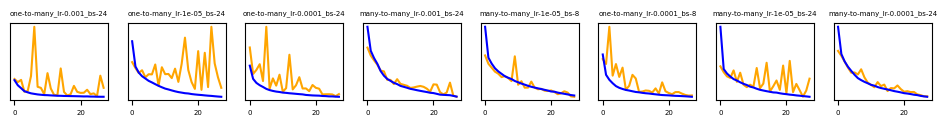

In [4]:
plot_losses(datapath,"runs-exp-18-11-2023",27)

In [11]:
summarize_eval(datapath,"runs-exp-18-11-2023", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,many-to-many_lr-0.0001_bs-24,2.792605,1.998135,0.866868,1.049151,2.854526,2.125407,0.879407,0.970231,0.998927,0.999879
1,many-to-many_lr-0.0001_bs-8,2.789234,1.993260,0.866119,1.049633,2.838643,2.094338,0.873270,0.992471,0.998654,0.999880
2,many-to-many_lr-0.001_bs-24,2.789005,1.991656,0.866514,1.050049,2.835408,2.085583,0.877903,1.000845,0.998617,0.999801
3,many-to-many_lr-0.001_bs-8,2.786195,1.991779,0.866549,1.050822,2.839366,2.094184,0.877632,0.999263,0.998437,0.999724
4,many-to-many_lr-1e-05_bs-24,2.788024,1.990150,0.866709,1.050695,2.801345,2.021275,0.860672,1.107349,0.999989,0.999988
5,many-to-many_lr-1e-05_bs-8,2.787288,1.993435,0.866230,1.050749,2.839811,2.103157,0.876933,1.009374,0.999883,0.999972
6,one-to-many_lr-0.0001_bs-24,2.470913,1.750308,0.900779,1.103646,2.783990,2.094574,0.904140,0.913602,0.997124,0.999694
7,one-to-many_lr-0.0001_bs-8,2.472859,1.747066,0.900035,1.102275,2.793292,2.116918,0.906913,0.892252,0.997353,0.999779
8,one-to-many_lr-0.001_bs-24,2.472379,1.748528,0.900662,1.101645,2.572778,1.831943,0.855065,1.005086,0.996392,0.999710
9,one-to-many_lr-0.001_bs-8,2.467431,1.742308,0.901678,1.103012,2.709755,2.009166,0.901923,0.907714,0.993417,0.999804


STFT Loss: 

- STFT loss is a measure of how close two audio signals are to each other, minimizing this loss is an objective of our network
- For almost all training parameters, after training the network the signal transformed by our approach is closer to the target then the input signal
- The average stft loss for many-to-many is lower than for one-to-many. Its because in many-to-many the input signal already has some amount of reverb, which makes it initially closer to the target. 
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (the transformation makes the signal further from the target!)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24

STYLE SIMILARITY: 

- Style similarity is the cosine similarity loss between the style embeddings of two audio signals
- The style similarity depends on the model training, that is why the values differ both for input and for prediction. 
- The objective of the training is to obtain a transformation which changes the style of signal, so that it is closer to the target at the output than at the input. This objective is fulfilled for most of the training parameters. If there is no difference in style before and after the transformation, than it probably means the encoder has not been trained properly. 
- For many-to-many the best parameters (leading to a biggest difference) are lr=0.001 and bs=8, and the worst is lr=1e-5 and bs=24 
- For one-to-many the best parameters are lr=0.001 and bs=8, and the worst is lr=1e-5 and bs=24
- This measure is not so informative as it depends both on the room encoding network and style transfer network 

PESQ SIMILARITY: 

- PESQ similarity is a similarity measure based on the PESQ score, which is typically used to compare clean and enhanced signals. Typically, the closer the enhanced signal to the clean signal, the higher the pesq value, which means the better performance of an enhancing algorithm. Here, we use this measure to compare PESQ(target signal, input signal) with PESQ(target signal, predicted signal). If our approach is working then PESQ(target signal, predicted signal) is higher than PESQ(target signal, input signal).
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (same as STFT loss)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24 (same as STFT Loss)
- In the korean study the PESQ goes from 2.643 to 3.105 in the best model  

STOI SIMILARITY: 

- STOI similarity is a similarity measure based on the STOI score, which is typically used to compare clean and enhanced signals. Typically, the closer the enhanced signal to the clean signal, the higher the STOI value, which means the better performance of an enhancing algorithm. Here, we use this measure to compare STOI(target signal, input signal) with STOI(target signal, predicted signal). If our approach is working then STOI(target signal, predicted signal) is higher than STOI(target signal, input signal).
- For many-to-many the best parameters are lr=1e-4 and bs=24, and the worst is lr=1e-5 and bs=24 (same as STFT loss)
- For one-to-many the best parameters are lr=1e-4 and bs=8, and the worst is lr=0.001 and bs=24 (same as STFT Loss)
- In the korean study the STOI goes from 78% to 80.92% in the best model

GENERAL OBSERVATIONS: 

- For many-to-many the condition with the lowest cumulative loss (lr=0.0001 and bs=8) is not the same condition as the one which corresponds to the lowest stft loss, and objective metrics (lr=0.0001 and bs=24), which means that trying to fulfill the second objective (style loss) is preventing the network from getting to low stft loss (?)
- For one-to-many the condition with the lowest cumulative loss is the same as the condition that leads to the lowest stft loss

###  <font color='fuchsia'>Compare training results: 11-12-2023 (best* conditions trained longer) - compare checkpoints
*actually for many-to-many is not the best condition, it is only the one that looks best based on the loss function (see 1 cell above)

 </font>

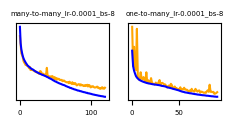

In [12]:
plot_losses(datapath,"runs-exp-11-12-2023","best")

In [14]:
summarize_eval(datapath,"runs-exp-11-12-2023", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,many-to-many_lr-0.0001_bs-8,2.788324,1.992269,0.866207,1.050408,2.907897,2.212275,0.887292,0.915007,0.998077,0.999501
1,one-to-many_lr-0.0001_bs-8,2.471330,1.744751,0.901425,1.099414,2.876911,2.226713,0.917384,0.854340,0.996203,0.999448


- Improvement for STOI is bigger for many-to-many than for one-to-many. 

    rev1 target:rev2 input -> rev1 target:rev1 prediction 
    is bigger than:
    rev1 target:anechoic input -> rev1 target:rev2 prediction

    Interpretation: Replacing false reverberation has a bigger impact on speech intelligibility than adding correct reverberation to the anechoic signal. 


- Improvement for PESQ is smaller for many-to-many than for one-to-many. 

    rev1 target:rev2 input -> rev1 target:rev1 prediction 
    is smaller than:
    rev1 target:anechoic input -> rev1 target:rev2 prediction 

    Interpretation: Adding correct reverberation to the anechoic signal has a bigger effect on speech quality than replacing the wrong reverberation. 



###  <font color='fuchsia'>Compare training results: 15-01-2024 (different loss functions)
 </font>

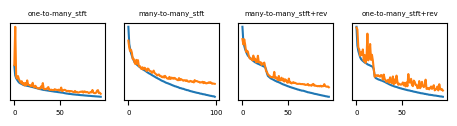

In [ ]:
plot_losses(datapath,"runs-exp-15-01-2024","best")

In [3]:
summarize_eval(datapath,"runs-exp-15-01-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,18-01-2024--00-56_many-to-many_stft,2.785063,1.989314,0.867151,1.050991,2.899321,2.203292,0.887710,0.919596,0.919174,0.971813
1,18-01-2024--14-13_many-to-many_stft+rev,2.788430,1.996256,0.867036,1.050626,2.889186,2.191147,0.885903,0.933133,0.925503,0.975560
2,19-01-2024--03-54_many-to-many_stft+emb,2.788701,1.995231,0.865863,1.049138,2.883911,2.173069,0.882874,0.947855,0.997936,0.999391
3,19-01-2024--18-08_many-to-many_stft+rev+emb,2.789627,1.993386,0.865548,1.050770,2.889063,2.183598,0.882396,0.941709,0.995789,0.998951


So far here it looks like the best results are achieved by STFT loss only...


###  <font color='fuchsia'>Compare training results: 22-01-2024 (more loss functions)
 </font>

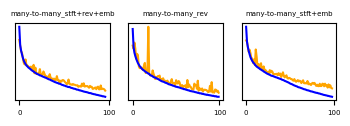

In [4]:
plot_losses(datapath,"runs-exp-22-01-2024","best")

In [71]:
summarize_eval(datapath,"runs-exp-22-01-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,22-01-2024--18-36_many-to-many_rev,2.789856,1.990917,0.866469,1.050406,2.842136,2.085734,0.866091,1.095309,0.937831,0.979793
1,23-01-2024--07-54_many-to-many_stft+emb,2.790451,1.992069,0.866646,1.050265,2.892618,2.182555,0.886652,0.935732,0.997357,0.999179
2,23-01-2024--22-05_many-to-many_stft+rev+emb,2.791655,1.997236,0.866010,1.051143,2.917615,2.229002,0.886512,0.920348,0.995666,0.998494


###  <font color='fuchsia'>Compare training results: 26-01-2024 (longer training)
 </font>

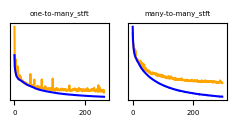

In [5]:
plot_losses(datapath,"runs-exp-26-01-2024","best")

In [6]:
summarize_eval(datapath,"runs-exp-26-01-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,28-01-2024--15-34_many-to-many_stft,2.789627,1.993386,0.865548,1.05077,2.941856,2.27219,0.893875,0.884298,0.901222,0.968116


In [7]:
summarize_eval2(datapath,"runs-exp-26-01-2024","eval_all_batches.csv","content:target", b_save=False)
summarize_eval2(datapath,"runs-exp-26-01-2024","eval_all_batches.csv","prediction:target", b_save=False)
summarize_eval2(datapath,"runs-exp-26-01-2024","eval_all_batches.csv","prediction:content", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,26-01-2024--17-13_one-to-many_stft,196.5,1.150181,2.828726,0.022092,-6.329193,NaN,5.920155,1.727407,0.904011,0.088582,13.526205
1,28-01-2024--15-34_many-to-many_stft,196.5,1.109119,1.679968,0.010387,1.719688,NaN,5.915324,1.974303,0.869342,0.050692,5.886257


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,26-01-2024--17-13_one-to-many_stft,196.5,0.849523,1.549242,0.008827,7.326093,7.860458,NaN,2.340714,0.925820,0.012788,4.720112
1,28-01-2024--15-34_many-to-many_stft,196.5,0.941020,1.008542,0.088041,4.847224,7.090151,NaN,2.246656,0.897784,0.016514,3.346675


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,26-01-2024--17-13_one-to-many_stft,196.5,0.988858,3.241743,0.022982,-5.188472,NaN,8.523850,2.278143,0.960161,0.053763,10.702994
1,28-01-2024--15-34_many-to-many_stft,196.5,0.702397,1.212455,0.088760,6.224136,NaN,5.903984,2.837830,0.936278,0.032277,4.695928


###  <font color='fuchsia'>Compare training results: 09-02-2024 (Rev+stft+emb loss alphas=[1,3,10])
 </font>

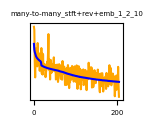

In [8]:
plot_losses(datapath,"runs-exp-09-02-2024","best")

In [9]:
summarize_eval(datapath,"runs-exp-09-02-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,09-02-2024--19-51_many-to-many_stft+rev+emb_1_...,2.789627,1.993386,0.865548,1.035635,2.93396,2.238769,0.887101,0.922667,0.998913,0.999734


###  <font color='fuchsia'>Compare training results: 15-02-2024 (Rev+stft, dropout, stft loss param updated)
 </font>

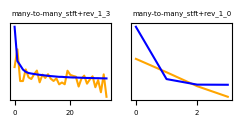

In [10]:
plot_losses(datapath,"runs-exp-15-02-2024","best")

###  <font color='fuchsia'>Compare training results: 19-02-2024 (Rev+stft, long training)
 </font>

In [11]:
summarize_eval(datapath,"runs-exp-19-02-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,19-02-2024--14-58_many-to-many_stft+rev+emb_1_1_1,2.782296,1.99659,0.863752,1.025906,2.963447,2.263071,0.885436,0.951342,0.996193,0.998627


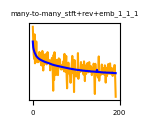

In [12]:
plot_losses(datapath,"runs-exp-19-02-2024","best")

### <font color='green'>Compare training results: 19-03-2024 (Pilot experiment (30 epochs) for symmetric film and early/late loss")
 </font>

In [13]:
summarize_eval(datapath,"runs-exp-19-03-2024", b_save=False)

,label,nb_pesq_input,pesq_input,stoi_input,stftloss_input,nb_pesq_predict,pesq_predict,stoi_predict,stftloss_predict,styleloss_input,styleloss_predict
0,19-03-2024--10-27_many-to-many_stft+early+late...,2.785100,2.003841,0.868674,1.026452,2.817645,2.019300,0.869404,1.210774,0.995200,0.997044
1,19-03-2024--18-03_many-to-many_early+late_1_1,2.787654,2.002353,0.867153,1.031052,2.782842,1.962580,0.855391,1.409368,0.941733,0.954271
2,20-03-2024--00-52_many-to-many_stft_1,2.796566,2.006454,0.866380,1.031974,2.866676,2.087556,0.877547,1.048846,0.890883,0.938060
3,20-03-2024--07-21_many-to-many_stft+early+late...,2.788849,1.993826,0.867377,1.018033,2.823590,2.001924,0.865665,1.242201,0.929401,0.947220


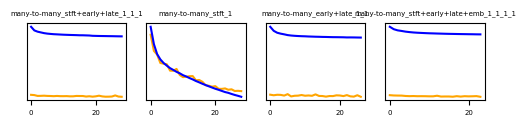

In [14]:
plot_losses(datapath,"runs-exp-19-03-2024","best") 

# Note : validation loss in graphs below is only valid for the second plot

### <font color='green'>Compare training results: 20-03-2024 (Big experiment (100 epochs) for symmetric film + different combinations of early/late/emb/stft/logmel losses")
 </font>

In [8]:
summarize_eval2(datapath,"runs-exp-20-03-2024","eval_all_batches.csv","content:target", b_save=False)

summarize_eval2(datapath,"runs-exp-20-03-2024","eval_all_batches.csv","prediction:target", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc,L_srmr_prediction,L_srmr_target,L_srmr_content
0,20-03-2024--18-27_many-to-many_early+late_1_1,196.5,1.107189,1.659719,0.010385,1.721730,NaN,NaN,1.979796,0.869096,0.039302,7.600622,NaN,5.920155,NaN
1,21-03-2024--19-56_many-to-many_stft_1,196.5,1.108565,1.674394,0.010349,1.726492,NaN,NaN,1.972400,0.868864,0.060104,4.588938,NaN,5.930379,NaN
2,22-03-2024--18-29_many-to-many_stft+early+late...,196.5,1.108654,1.666696,0.010402,1.719196,NaN,NaN,1.976771,0.869278,0.025451,123.100314,NaN,5.926841,NaN
3,23-03-2024--18-55_many-to-many_stft+early+late...,196.5,1.108778,1.686023,0.010327,1.730155,NaN,NaN,1.978014,0.868770,0.002454,4.201448,NaN,5.928729,NaN
4,25-03-2024--12-45_many-to-many_stft+early+late...,196.5,1.108580,1.681050,0.010348,1.722999,NaN,NaN,1.975746,0.869196,0.050654,7.220165,NaN,5.931729,NaN
5,26-03-2024--12-58_many-to-many_stft+emb_1_1,196.5,1.109119,1.679968,0.010387,1.719688,NaN,NaN,1.974303,0.869342,0.001040,2.155601,NaN,5.915324,NaN
6,27-03-2024--13-51_many-to-many_stft+logmel_1_1,196.5,1.107515,1.679874,0.010369,1.722639,NaN,NaN,1.977825,0.869336,0.038415,1.509750,NaN,5.925113,NaN
7,28-03-2024--11-24_many-to-many_stft+early+late...,196.5,1.108020,1.681383,0.010355,1.719079,NaN,NaN,1.973204,0.868902,0.049792,4.078287,NaN,5.917769,NaN


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc,L_srmr_prediction,L_srmr_target,L_srmr_content
0,20-03-2024--18-27_many-to-many_early+late_1_1,196.5,1.406378,2.834825,0.025607,0.019601,NaN,NaN,2.034767,0.854478,0.019751,5.548678,5.251957,NaN,NaN
1,21-03-2024--19-56_many-to-many_stft_1,196.5,0.947435,1.004521,0.006661,4.484550,NaN,NaN,2.286428,0.897862,0.020490,2.667762,6.900744,NaN,NaN
2,22-03-2024--18-29_many-to-many_stft+early+late...,196.5,1.120605,1.578246,0.015381,1.378105,NaN,NaN,2.169067,0.879096,0.009971,77.140177,6.146706,NaN,NaN
3,23-03-2024--18-55_many-to-many_stft+early+late...,196.5,1.112453,1.479769,0.016668,0.559075,NaN,NaN,2.179634,0.878888,0.000875,2.520692,6.251364,NaN,NaN
4,25-03-2024--12-45_many-to-many_stft+early+late...,196.5,0.981907,1.150246,0.009596,3.375805,NaN,NaN,2.266569,0.894666,0.019063,4.435405,6.737285,NaN,NaN
5,26-03-2024--12-58_many-to-many_stft+emb_1_1,196.5,0.967086,1.123332,0.007331,4.219378,NaN,NaN,2.277130,0.896438,0.000333,1.225047,6.844353,NaN,NaN
6,27-03-2024--13-51_many-to-many_stft+logmel_1_1,196.5,1.029223,0.958061,0.009857,2.375989,NaN,NaN,2.210972,0.885474,0.006072,0.593630,6.416657,NaN,NaN
7,28-03-2024--11-24_many-to-many_stft+early+late...,196.5,0.969071,1.055663,0.008557,3.281685,NaN,NaN,2.279234,0.894446,0.016726,2.347812,6.510814,NaN,NaN


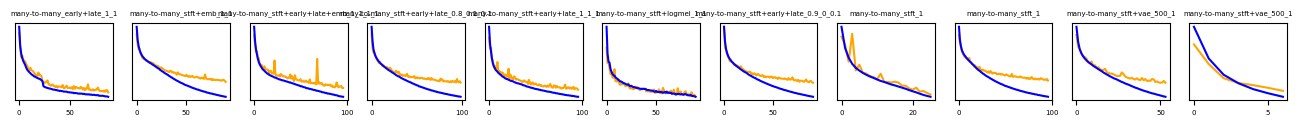

In [13]:
plot_losses(datapath,"runs-exp-20-03-2024","best") 

### <font color='green'>Compare training results: 28-03-2024 (400 epochs, symmetric film + stft/log/stft+log)
 </font>

In [7]:
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_all_batches.csv","content:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_all_batches.csv","prediction:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_all_batches.csv","prediction:content", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,196.5,1.108778,1.686023,0.010327,1.730155,NaN,5.928729,1.978014,0.868770,0.049594,4.113309
1,07-04-2024--05-35_many-to-many_logmel_1,196.5,1.109119,1.679968,0.010387,1.719688,NaN,5.915324,1.974303,0.869342,0.018160,1.212485
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,196.5,1.107189,1.659719,0.010385,1.721730,NaN,5.920155,1.979796,0.869096,0.025180,1.714109


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,196.5,0.926924,0.969754,0.006000,5.146300,6.753104,NaN,2.361190,0.904243,0.013957,2.175125
1,07-04-2024--05-35_many-to-many_logmel_1,196.5,1.022464,0.853852,0.009653,2.150422,5.185755,NaN,2.258954,0.889075,0.004593,0.610921
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,196.5,0.964729,0.829319,0.007790,3.634715,6.626264,NaN,2.360700,0.899504,0.004454,0.718290


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,196.5,0.717646,1.236519,0.005990,5.556045,NaN,5.923302,2.765548,0.928245,0.037559,3.566022
1,07-04-2024--05-35_many-to-many_logmel_1,196.5,0.598550,1.054819,0.002326,13.741847,NaN,5.903984,3.443924,0.969811,0.012468,1.004385
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,196.5,0.685705,1.204882,0.003899,8.448428,NaN,5.901265,3.166672,0.950649,0.018981,1.480058


In [8]:
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_dereverb.csv","content:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_dereverb.csv","prediction:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_dereverb.csv","prediction:content", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,58.0,1.173756,2.237316,0.010672,1.563526,NaN,5.354827,1.856457,0.862359,0.060049,4.512693
1,07-04-2024--05-35_many-to-many_logmel_1,58.0,1.174563,2.204801,0.010695,1.576713,NaN,5.366323,1.862340,0.861623,0.026448,1.468789
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,58.0,1.178976,2.248610,0.010745,1.539396,NaN,5.380116,1.850264,0.862102,0.035993,2.050243


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,58.0,0.949297,0.969837,0.006361,4.789204,6.443159,NaN,2.226916,0.893151,0.012969,2.067202
1,07-04-2024--05-35_many-to-many_logmel_1,58.0,1.040790,0.856094,0.010095,1.856508,4.916006,NaN,2.174721,0.877742,0.006072,0.701174
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,58.0,0.987229,0.854557,0.008093,3.358207,6.189347,NaN,2.231975,0.888735,0.004430,0.706216


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,58.0,0.789271,1.766697,0.006121,5.404587,NaN,6.443436,2.614061,0.930830,0.045084,3.898076
1,07-04-2024--05-35_many-to-many_logmel_1,58.0,0.634374,1.448198,0.001839,13.716241,NaN,6.425617,3.090177,0.972708,0.012536,1.007839
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,58.0,0.783076,1.803939,0.004073,8.092639,NaN,6.437261,2.870033,0.950563,0.024900,1.698549


In [6]:
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_rereverb.csv","content:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_rereverb.csv","prediction:target", b_save=False)
summarize_eval2(datapath,"runs-exp-28-03-2024","eval_rereverb.csv","prediction:content", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,62.0,1.171343,2.248290,0.010318,1.653517,NaN,6.546787,1.863513,0.868631,0.060242,4.545442
1,07-04-2024--05-35_many-to-many_logmel_1,62.0,1.169670,2.260534,0.010460,1.658216,NaN,6.516980,1.860798,0.868845,0.026019,1.459137
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,62.0,1.165076,2.216619,0.010462,1.651974,NaN,6.455578,1.855753,0.869320,0.035211,2.036807


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,62.0,0.936670,1.175837,0.005471,5.556458,7.123307,NaN,2.371120,0.912122,0.016055,2.353778
1,07-04-2024--05-35_many-to-many_logmel_1,62.0,1.043189,1.012659,0.008831,2.325059,5.491674,NaN,2.267074,0.897366,0.004499,0.605446
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,62.0,0.982784,0.962998,0.007586,3.865292,7.102117,NaN,2.379879,0.907475,0.005192,0.783683


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,02-04-2024--14-14_many-to-many_stft_1,62.0,0.790837,1.453548,0.006387,5.208703,NaN,5.490211,2.592386,0.918609,0.045884,3.944800
1,07-04-2024--05-35_many-to-many_logmel_1,62.0,0.702670,1.473501,0.002523,12.684887,NaN,5.445382,3.183214,0.955399,0.021192,1.314410
2,28-03-2024--19-41_many-to-many_stft+logmel_1_1,62.0,0.765578,1.542079,0.004524,7.872548,NaN,5.431687,2.884677,0.938036,0.028533,1.818972


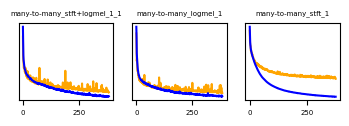

In [16]:
plot_losses(datapath,"runs-exp-28-03-2024","best") 

### <font color='blue'>Compare training results: 14-04-2024 (100 epochs, symmetric film, JOINT optimizer, normal and variational version, but potentially error in the variational loss)
 </font>

In [11]:
summarize_eval2(datapath,"runs-exp-14-04-2024","eval_all_batches.csv","content:target", b_save=False)
summarize_eval2(datapath,"runs-exp-14-04-2024","eval_all_batches.csv","prediction:target", b_save=False)
summarize_eval2(datapath,"runs-exp-14-04-2024","eval_all_batches.csv","prediction:content", b_save=False)

,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,14-04-2024--00-22_many-to-many_stft+vae_1_1,196.5,1.108579,1.664007,0.010366,1.716899,NaN,5.942671,1.980501,0.868835,0.030416,3.300954
1,15-04-2024--01-55_many-to-many_stft_1,196.5,1.108055,1.685483,0.010289,1.725225,NaN,5.936276,1.980483,0.868943,0.035529,2.494637


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,14-04-2024--00-22_many-to-many_stft+vae_1_1,196.5,0.996117,1.132215,0.085502,3.010704,6.891803,NaN,2.201189,0.887523,0.013352,2.184366
1,15-04-2024--01-55_many-to-many_stft_1,196.5,0.997368,1.149301,0.008409,3.303706,6.817073,NaN,2.185713,0.886889,0.010645,1.361556


,label,idx,L_stft2,L_logmel,L_wav_L2,L_si_sdr,L_srmr_x1,L_srmr_x2,L_pesq,L_stoi,L_emb_cosine,L_emb_euc
0,14-04-2024--00-22_many-to-many_stft+vae_1_1,196.5,0.681886,1.204375,0.088929,6.484297,NaN,5.927219,3.045472,0.942035,0.029825,3.266772
1,15-04-2024--01-55_many-to-many_stft_1,196.5,0.666210,1.212182,0.004216,7.772437,NaN,5.911086,3.040739,0.943367,0.028428,2.228228


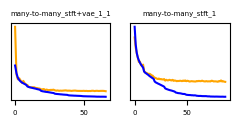

In [14]:
plot_losses(datapath,"runs-exp-14-04-2024","best") 